In [2]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR


In [1]:
# Load the data
Withbinaries = np.load("FirstData.npy", allow_pickle=True)

# Split the data into features and labels
X = Withbinaries[:, 1:-1]  # All columns except the last one
y = Withbinaries[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the neural network in PyTorch
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

# Model parameters
input_size = X_train.shape[1]
num_classes = len(np.unique(ypreencode))
model = NeuralNet(input_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), "star_classifier_first.pth")


Epoch [1/50], Loss: 3.1002
Epoch [2/50], Loss: 2.6061
Epoch [3/50], Loss: 2.9541
Epoch [4/50], Loss: 2.8415
Epoch [5/50], Loss: 2.8973
Epoch [6/50], Loss: 2.8765
Epoch [7/50], Loss: 2.8407
Epoch [8/50], Loss: 2.9002
Epoch [9/50], Loss: 2.8414
Epoch [10/50], Loss: 2.8414
Epoch [11/50], Loss: 2.8979
Epoch [12/50], Loss: 3.0176
Epoch [13/50], Loss: 2.9002
Epoch [14/50], Loss: 2.7237
Epoch [15/50], Loss: 2.7826
Epoch [16/50], Loss: 3.0731
Epoch [17/50], Loss: 2.9002
Epoch [18/50], Loss: 2.9536
Epoch [19/50], Loss: 2.7826
Epoch [20/50], Loss: 2.8414
Epoch [21/50], Loss: 2.7826
Epoch [22/50], Loss: 2.7299
Epoch [23/50], Loss: 2.7832
Epoch [24/50], Loss: 2.9528
Epoch [25/50], Loss: 2.7237
Epoch [26/50], Loss: 2.9002
Epoch [27/50], Loss: 2.7237
Epoch [28/50], Loss: 3.0179
Epoch [29/50], Loss: 2.9590
Epoch [30/50], Loss: 2.9002
Epoch [31/50], Loss: 2.7826
Epoch [32/50], Loss: 2.7826
Epoch [33/50], Loss: 2.9590
Epoch [34/50], Loss: 2.8414
Epoch [35/50], Loss: 2.9590
Epoch [36/50], Loss: 2.6649
E

#### Check cuda is on

In [5]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.get_device_name(0))  # Prints the name of your GPU

True
NVIDIA GeForce RTX 3080 Laptop GPU


# Try with 4 categories naively

In [12]:
FirstData = np.load("FirstData.npy", allow_pickle=True)
print(FirstData.shape)
X = FirstData[:, 1:-1]  # All columns except the last one
y = FirstData[:, -1]    # The last column

Macondition = np.isin(y, ["bC*", "sg*", "s*r", "s*y", "s*b", "WR*", "N*", "Psr"])
y4cat = np.where(Macondition, "Ma*", y)
YOcondition = np.isin(y, ["Or*", "TT*", "out", "Ae*", "HH"])
y4cat = np.where(YOcondition, "Y*O", y4cat)
MScondition = np.isin(y, ["Be*", "BS*", "SX*", "gD*", "dS*"])
y4cat = np.where(MScondition, "MS*", y4cat)
Evcondition = np.isin(y, ["RG*", "HS*", "RR*", "HB*", "WV*", "Ce*", "cC*", "C*", "S*", "LP*", "AS*", "AB*", "Mi*", "OH*", "pA*", "RV*", "PN", "WD*"])
y4cat = np.where(Evcondition, "Ev*", y4cat)

(84674, 14)


In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("cat4.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
ypostencode = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(ypostencode, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), "star_classifier_y4cat.pth")

Running on  cuda  cores


Epoch 1/50: 100%|██████████| 1985/1985 [00:09<00:00, 201.61batch/s, Loss=3.7172]



Test Accuracy after Epoch 1: 0.9184


Epoch 2/50: 100%|██████████| 1985/1985 [00:09<00:00, 201.07batch/s, Loss=3.5298]



Test Accuracy after Epoch 2: 0.8660


Epoch 3/50: 100%|██████████| 1985/1985 [00:10<00:00, 195.29batch/s, Loss=3.5170]



Test Accuracy after Epoch 3: 0.9303


Epoch 4/50: 100%|██████████| 1985/1985 [00:09<00:00, 215.35batch/s, Loss=3.8421]



Test Accuracy after Epoch 4: 0.9014


Epoch 5/50: 100%|██████████| 1985/1985 [00:09<00:00, 216.94batch/s, Loss=3.5218]



Test Accuracy after Epoch 5: 0.9224


Epoch 6/50: 100%|██████████| 1985/1985 [00:08<00:00, 225.80batch/s, Loss=3.5319]



Test Accuracy after Epoch 6: 0.9249


Epoch 7/50: 100%|██████████| 1985/1985 [00:09<00:00, 213.51batch/s, Loss=3.5268]



Test Accuracy after Epoch 7: 0.8603


Epoch 8/50: 100%|██████████| 1985/1985 [00:09<00:00, 207.09batch/s, Loss=3.7099]



Test Accuracy after Epoch 8: 0.8575


Epoch 9/50: 100%|██████████| 1985/1985 [00:10<00:00, 197.53batch/s, Loss=3.5557]



Test Accuracy after Epoch 9: 0.8948


Epoch 10/50: 100%|██████████| 1985/1985 [00:10<00:00, 198.31batch/s, Loss=3.9344]



Test Accuracy after Epoch 10: 0.8876


Epoch 11/50: 100%|██████████| 1985/1985 [00:09<00:00, 206.51batch/s, Loss=3.6745]



Test Accuracy after Epoch 11: 0.8699


Epoch 12/50: 100%|██████████| 1985/1985 [00:09<00:00, 213.37batch/s, Loss=3.5425]



Test Accuracy after Epoch 12: 0.8991


Epoch 13/50: 100%|██████████| 1985/1985 [00:09<00:00, 209.35batch/s, Loss=3.6763]



Test Accuracy after Epoch 13: 0.8962


Epoch 14/50: 100%|██████████| 1985/1985 [00:09<00:00, 216.42batch/s, Loss=3.6997]



Test Accuracy after Epoch 14: 0.9124


Epoch 15/50: 100%|██████████| 1985/1985 [00:09<00:00, 201.76batch/s, Loss=3.6345]



Test Accuracy after Epoch 15: 0.8839


Epoch 16/50: 100%|██████████| 1985/1985 [00:09<00:00, 205.40batch/s, Loss=3.7143]



Test Accuracy after Epoch 16: 0.9360


Epoch 17/50: 100%|██████████| 1985/1985 [00:09<00:00, 213.31batch/s, Loss=4.3184]



Test Accuracy after Epoch 17: 0.8733


Epoch 18/50: 100%|██████████| 1985/1985 [00:09<00:00, 199.04batch/s, Loss=4.3094]



Test Accuracy after Epoch 18: 0.9205


Epoch 19/50: 100%|██████████| 1985/1985 [00:08<00:00, 222.60batch/s, Loss=4.3037]



Test Accuracy after Epoch 19: 0.8838


Epoch 20/50: 100%|██████████| 1985/1985 [00:08<00:00, 223.75batch/s, Loss=4.3728]



Test Accuracy after Epoch 20: 0.9123


Epoch 21/50: 100%|██████████| 1985/1985 [00:09<00:00, 206.10batch/s, Loss=4.3287]



Test Accuracy after Epoch 21: 0.9404


Epoch 22/50: 100%|██████████| 1985/1985 [00:09<00:00, 210.28batch/s, Loss=4.4721]



Test Accuracy after Epoch 22: 0.8643


Epoch 23/50: 100%|██████████| 1985/1985 [00:09<00:00, 202.40batch/s, Loss=4.3906]



Test Accuracy after Epoch 23: 0.6291


Epoch 24/50: 100%|██████████| 1985/1985 [00:09<00:00, 211.07batch/s, Loss=4.3636]



Test Accuracy after Epoch 24: 0.9320


Epoch 25/50: 100%|██████████| 1985/1985 [00:09<00:00, 203.57batch/s, Loss=4.3166]



Test Accuracy after Epoch 25: 0.8953


Epoch 26/50: 100%|██████████| 1985/1985 [00:10<00:00, 196.08batch/s, Loss=4.1824]



Test Accuracy after Epoch 26: 0.9146


Epoch 27/50: 100%|██████████| 1985/1985 [00:10<00:00, 181.73batch/s, Loss=4.0758]



Test Accuracy after Epoch 27: 0.8936


Epoch 28/50: 100%|██████████| 1985/1985 [00:09<00:00, 200.96batch/s, Loss=3.5212]



Test Accuracy after Epoch 28: 0.8948


Epoch 29/50: 100%|██████████| 1985/1985 [00:10<00:00, 198.46batch/s, Loss=3.6356]



Test Accuracy after Epoch 29: 0.8746


Epoch 30/50: 100%|██████████| 1985/1985 [00:10<00:00, 191.63batch/s, Loss=3.6166]



Test Accuracy after Epoch 30: 0.9119


Epoch 31/50: 100%|██████████| 1985/1985 [00:09<00:00, 198.77batch/s, Loss=3.9188]



Test Accuracy after Epoch 31: 0.8945


Epoch 32/50: 100%|██████████| 1985/1985 [00:09<00:00, 215.66batch/s, Loss=3.6142]



Test Accuracy after Epoch 32: 0.8982


Epoch 33/50: 100%|██████████| 1985/1985 [00:08<00:00, 222.15batch/s, Loss=3.6580]



Test Accuracy after Epoch 33: 0.9337


Epoch 34/50: 100%|██████████| 1985/1985 [00:08<00:00, 232.08batch/s, Loss=4.1901]



Test Accuracy after Epoch 34: 0.9569


Epoch 35/50: 100%|██████████| 1985/1985 [00:08<00:00, 226.13batch/s, Loss=3.9447]



Test Accuracy after Epoch 35: 0.8934


Epoch 36/50: 100%|██████████| 1985/1985 [00:09<00:00, 219.02batch/s, Loss=3.6510]



Test Accuracy after Epoch 36: 0.8839


Epoch 37/50: 100%|██████████| 1985/1985 [00:11<00:00, 179.76batch/s, Loss=3.6972]



Test Accuracy after Epoch 37: 0.9005


Epoch 38/50: 100%|██████████| 1985/1985 [00:09<00:00, 215.34batch/s, Loss=3.8793]



Test Accuracy after Epoch 38: 0.9330


Epoch 39/50: 100%|██████████| 1985/1985 [00:09<00:00, 211.46batch/s, Loss=3.8113]



Test Accuracy after Epoch 39: 0.9361


Epoch 40/50: 100%|██████████| 1985/1985 [00:09<00:00, 207.24batch/s, Loss=3.5837]



Test Accuracy after Epoch 40: 0.8626


Epoch 41/50: 100%|██████████| 1985/1985 [00:09<00:00, 211.27batch/s, Loss=3.6979]



Test Accuracy after Epoch 41: 0.9015


Epoch 42/50: 100%|██████████| 1985/1985 [00:08<00:00, 220.87batch/s, Loss=3.8339]



Test Accuracy after Epoch 42: 0.9382


Epoch 43/50:  19%|█▉        | 383/1985 [00:01<00:07, 226.75batch/s, Loss=0.7494]

In [11]:
# Load the saved model
model.load_state_dict(torch.load('star_classifier_y4cat.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(y_batch.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.categories_[0][unique_labels])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

C:\Users\jcwin\AppData\Local\Temp\ipykernel_9908\3098918948.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('star_classifier_y4cat.pth')

Confusion Matrix:
 [[18827   146     0   215]
 [   60   118     0    32]
 [  116     2     0     3]
 [   73    72     0  1505]]
Classification Report:
               precision    recall  f1-score   support

         Ev*       0.99      0.98      0.98     19188
         MS*       0.35      0.56      0.43       210
         Ma*       0.00      0.00      0.00       121
         Y*O       0.86      0.91      0.88      1650

    accuracy                           0.97     21169
   macro avg       0.55      0.61      0.57     21169
weighted avg       0.96      0.97      0.97     21169



C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

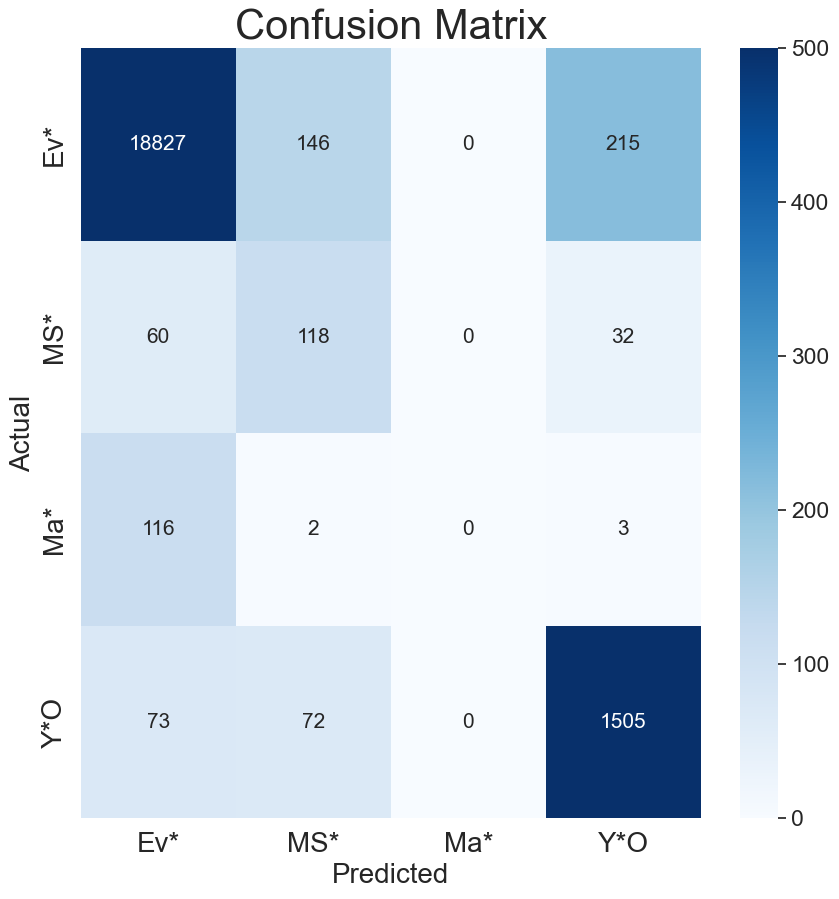

In [37]:
# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()